Wandb Report Link: 
https://wandb.ai/drbean/Logistic-regression/reports/Question-1---Vmlldzo1NzkwOTcx

In [41]:
import sys
import wandb
import warnings
import numpy as np
import pandas as pd

from prettytable import PrettyTable
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [42]:
data = pd.read_csv('WineQT.csv')
data.drop_duplicates(inplace=True)
data = data.drop(columns=['Id'])
# print(data.shape)

# Dataset Analysis and Preprocessing
columns = data.columns
t = PrettyTable(['Attribute', 'Mean', 'Standard Deviation', 'min Value', 'max value'])
for attr in columns:
    col = data[attr]
    mean = round(col.mean(), 4)
    std = round(col.std(), 4)
    t.add_row([attr, mean, std, col.min(), col.max()])
print(t)

+----------------------+---------+--------------------+-----------+-----------+
|      Attribute       |   Mean  | Standard Deviation | min Value | max value |
+----------------------+---------+--------------------+-----------+-----------+
|    fixed acidity     |  8.3111 |       1.7476       |    4.6    |    15.9   |
|   volatile acidity   |  0.5313 |       0.1796       |    0.12   |    1.58   |
|     citric acid      |  0.2684 |       0.1967       |    0.0    |    1.0    |
|    residual sugar    |  2.5322 |       1.3559       |    0.9    |    15.5   |
|      chlorides       |  0.0869 |       0.0473       |   0.012   |   0.611   |
| free sulfur dioxide  | 15.6155 |      10.2505       |    1.0    |    68.0   |
| total sulfur dioxide | 45.9147 |      32.7821       |    6.0    |   289.0   |
|       density        |  0.9967 |       0.0019       |  0.99007  |  1.00369  |
|          pH          |  3.311  |       0.1567       |    2.74   |    4.01   |
|      sulphates       |  0.6577 |      

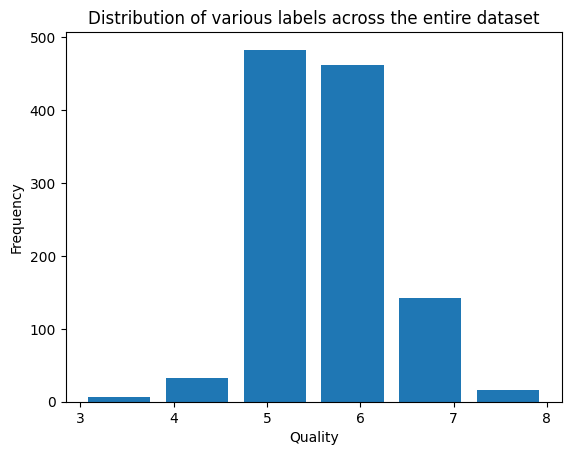

In [43]:

# Distribution of various labels across the entire dataset
labels = data['quality']
plt.hist(labels, bins=len(np.unique(labels)), rwidth=0.8)
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of various labels across the entire dataset')
plt.show()

In [44]:

# Split the data into attributes and labels
X = data.iloc[:,data.columns != 'quality']
Y = data['quality']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Apply Normalization to the attributes
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Apply Standardization to the attributes
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert labels into one-hot vectors
Y = Y - Y.min()
temp = np.zeros((Y.size, Y.max()+1))
temp[np.arange(Y.size), Y] = 1
Y = temp

# Split the data into train, test and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, train_size=0.7, stratify=Y)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp)

In [45]:
class LogistricRegression:
    def __init__(self, n, num, attr, learn_rate=0.001, n_epochs=100):
        self.n = n
        self.num = num
        self.attr = attr
        self.n_epochs = n_epochs
        self.learn_rate = learn_rate
        self.weights = np.zeros((attr, num))
        self.bias = np.zeros((1, num))

    # Loss function
    def cross_entropy_loss(self, y_true, y_pred, epsilon=1e-18):
        y_pred = np.clip(y_pred, epsilon, 1-epsilon)
        loss = -np.sum(y_true * np.log(y_pred+1e-9)) / self.n
        return loss
    
    # Gradient Descent step
    def gradient_descent(self, X, y_true, y_pred):
        error = y_pred - y_true
        dw = np.dot(X.T, error) / self.n
        db = np.sum(error) / self.n
        return dw, db

    # softmax activation function
    def softmax(self, X):
        e_x = np.exp(X - np.max(X, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)
    
    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return y_pred
    
    def fit(self, X, Y):
        for _ in range(self.n_epochs):
            y_pred = self.predict(X)
            dw, db = self.gradient_descent(X, Y, y_pred)
            self.weights -= self.learn_rate*dw
            self.bias -= self.learn_rate*db
            loss = self.cross_entropy_loss(Y, y_pred)
            accuracy = self.accuracy(Y, y_pred)
            print('Epoch: {}/{} Loss: {:.4f} Accuracy: {:.4f}'.format(1+_, self.n_epochs, loss, accuracy))

    def fit_wandb(self, x_train, y_train, x_valid, y_valid):
        for _ in range(self.n_epochs):
            y_pred = self.predict(x_train)
            dw, db = self.gradient_descent(x_train, y_train, y_pred)
            self.weights -= self.learn_rate*dw
            self.bias -= self.learn_rate*db

            y_pred = self.predict(x_valid)
            loss = self.cross_entropy_loss(y_valid, y_pred)
            accuracy = self.accuracy(y_valid, y_pred)
            # print('Epoch: {}/{} Loss: {:.4f} Accuracy: {:.4f}'.format(1+_, self.n_epochs, loss, accuracy))
            wandb.log({"Loss": loss, "Accuracy": accuracy})
    
    def accuracy(self, y_true, y_pred):
        true_labels = np.argmax(y_true, axis=1)
        pred_labels = np.argmax(y_pred, axis=1)
        accuracy = np.mean(true_labels == pred_labels)
        return accuracy

In [49]:
# X -- n x attr
# Y -- n x num
# W -- attr x num
# b -- 1 x num
n, attr = x_train.shape
n, num = y_train.shape

# create a model and train
model = LogistricRegression(n, num, attr, 0.1, 100)
model.fit(x_train, y_train)

# Evaluate on validation data
y_pred = model.predict(x_valid)
report = classification_report(np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1))
print(report)

# Predict on test data
y_pred = model.predict(x_test)
loss = model.cross_entropy_loss(y_test, y_pred)
accuracy = model.accuracy(y_test, y_pred)
print('Test [Loss: {:.4f} Accuracy: {:.4f}]'.format(loss, accuracy))

Epoch: 1/100 Loss: 1.7918 Accuracy: 0.0050
Epoch: 2/100 Loss: 1.7759 Accuracy: 0.5125
Epoch: 3/100 Loss: 1.7610 Accuracy: 0.5138
Epoch: 4/100 Loss: 1.7469 Accuracy: 0.5138
Epoch: 5/100 Loss: 1.7335 Accuracy: 0.5138
Epoch: 6/100 Loss: 1.7209 Accuracy: 0.5138
Epoch: 7/100 Loss: 1.7089 Accuracy: 0.5138
Epoch: 8/100 Loss: 1.6976 Accuracy: 0.5150
Epoch: 9/100 Loss: 1.6868 Accuracy: 0.5138
Epoch: 10/100 Loss: 1.6766 Accuracy: 0.5138
Epoch: 11/100 Loss: 1.6669 Accuracy: 0.5138
Epoch: 12/100 Loss: 1.6577 Accuracy: 0.5138
Epoch: 13/100 Loss: 1.6490 Accuracy: 0.5138
Epoch: 14/100 Loss: 1.6406 Accuracy: 0.5125
Epoch: 15/100 Loss: 1.6327 Accuracy: 0.5150
Epoch: 16/100 Loss: 1.6252 Accuracy: 0.5138
Epoch: 17/100 Loss: 1.6180 Accuracy: 0.5138
Epoch: 18/100 Loss: 1.6112 Accuracy: 0.5138
Epoch: 19/100 Loss: 1.6046 Accuracy: 0.5125
Epoch: 20/100 Loss: 1.5984 Accuracy: 0.5125
Epoch: 21/100 Loss: 1.5924 Accuracy: 0.5138
Epoch: 22/100 Loss: 1.5867 Accuracy: 0.5138
Epoch: 23/100 Loss: 1.5813 Accuracy: 0.51

In [47]:
wandb.login()

True

In [48]:
# Hyperparameter tuning using wandb
learn_rate = [0.1, 0.01, 0.001]
epochs = [100, 1000, 10000]

for n_epoch in epochs:
    for rate in learn_rate:
        str = 'epoch:{} lr:{}'.format(n_epoch, rate)
        wandb.init(project="Logistic-regression", config={"learning_rate": rate, "epochs": n_epoch}, name=str)
        # training data
        model = LogistricRegression(n, num, attr, rate, n_epoch)
        model.fit_wandb(x_train, y_train, x_valid, y_valid)
        print('Number of Epochs: {} Learning Rate: {}'.format(n_epoch, rate))

        # validation data
        y_pred = model.predict(x_valid)
        loss = model.cross_entropy_loss(y_valid, y_pred)
        accuracy = model.accuracy(y_valid, y_pred)
        print('Validation [Loss: {:.4f} Accuracy: {:.4f}]'.format(loss, accuracy))

        # testing data
        y_pred = model.predict(x_test)
        report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        print('Testset Classification Report: \n', report)
        wandb.finish()

Number of Epochs: 100 Learning Rate: 0.1
Validation [Loss: 0.3318 Accuracy: 0.4678]
Testset Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.17      0.20      0.18         5
           2       0.70      0.78      0.74        73
           3       0.76      0.42      0.54        69
           4       0.36      0.77      0.49        22
           5       0.00      0.00      0.00         2

    accuracy                           0.60       172
   macro avg       0.33      0.36      0.33       172
weighted avg       0.66      0.60      0.60       172



Accuracy,██▆▆▆▆▆▆▆▇▇▇▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▃▃▃▃▃▁▁▁▁▁▁▁▁
Loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.46784
Loss,0.33178


Number of Epochs: 100 Learning Rate: 0.01
Validation [Loss: 0.3611 Accuracy: 0.4971]
Testset Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.71      0.82      0.76        73
           3       0.79      0.39      0.52        69
           4       0.35      0.82      0.49        22
           5       0.00      0.00      0.00         2

    accuracy                           0.61       172
   macro avg       0.31      0.34      0.30       172
weighted avg       0.67      0.61      0.60       172



Accuracy,██████████████████▁▁▁▁▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Accuracy,0.49708
Loss,0.36106


Number of Epochs: 100 Learning Rate: 0.001
Validation [Loss: 0.3802 Accuracy: 0.5088]
Testset Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.71      0.82      0.76        73
           3       0.77      0.39      0.52        69
           4       0.33      0.77      0.47        22
           5       0.00      0.00      0.00         2

    accuracy                           0.60       172
   macro avg       0.30      0.33      0.29       172
weighted avg       0.66      0.60      0.59       172



Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Accuracy,0.50877
Loss,0.38017


Number of Epochs: 1000 Learning Rate: 0.1
Validation [Loss: 0.3343 Accuracy: 0.5146]
Testset Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.69      0.78      0.73        73
           3       0.62      0.42      0.50        69
           4       0.32      0.55      0.41        22
           5       0.00      0.00      0.00         2

    accuracy                           0.57       172
   macro avg       0.27      0.29      0.27       172
weighted avg       0.58      0.57      0.56       172



Accuracy,▄▄▃▂▁▂▂▃▃▅▆▆▇▇▇▇████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆
Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
Accuracy,0.51462
Loss,0.33427


Number of Epochs: 1000 Learning Rate: 0.01
Validation [Loss: 0.3318 Accuracy: 0.4678]
Testset Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.17      0.20      0.18         5
           2       0.70      0.78      0.74        73
           3       0.76      0.42      0.54        69
           4       0.36      0.77      0.49        22
           5       0.00      0.00      0.00         2

    accuracy                           0.60       172
   macro avg       0.33      0.36      0.33       172
weighted avg       0.66      0.60      0.60       172



Accuracy,██▇▆▆▆▆▆▆▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▃▃▃▃▃▂▁▁▁▁▁▁▁
Loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.46784
Loss,0.33175


Number of Epochs: 1000 Learning Rate: 0.001
Validation [Loss: 0.3611 Accuracy: 0.4971]
Testset Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.71      0.82      0.76        73
           3       0.79      0.39      0.52        69
           4       0.35      0.82      0.49        22
           5       0.00      0.00      0.00         2

    accuracy                           0.61       172
   macro avg       0.31      0.34      0.30       172
weighted avg       0.67      0.61      0.60       172



Accuracy,██████████████████▁▁▁▁▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Accuracy,0.49708
Loss,0.36108


Number of Epochs: 10000 Learning Rate: 0.1
Validation [Loss: 0.3364 Accuracy: 0.5322]
Testset Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.68      0.75      0.71        73
           3       0.61      0.41      0.49        69
           4       0.33      0.59      0.42        22
           5       0.00      0.00      0.00         2

    accuracy                           0.56       172
   macro avg       0.27      0.29      0.27       172
weighted avg       0.57      0.56      0.55       172



Accuracy,▁▆▇▆▆▆▇▇▇▇▇█████▇▇▇▇▇▇▇█████████████████
Loss,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████████████████████████
Accuracy,0.53216
Loss,0.33641


Number of Epochs: 10000 Learning Rate: 0.01
Validation [Loss: 0.3343 Accuracy: 0.5146]
Testset Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.69      0.78      0.73        73
           3       0.62      0.42      0.50        69
           4       0.32      0.55      0.41        22
           5       0.00      0.00      0.00         2

    accuracy                           0.57       172
   macro avg       0.27      0.29      0.27       172
weighted avg       0.58      0.57      0.56       172



Accuracy,▄▅▃▂▁▂▂▃▃▅▆▆▆▇▇▇████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆
Loss,█▄▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Accuracy,0.51462
Loss,0.33427


Number of Epochs: 10000 Learning Rate: 0.001
Validation [Loss: 0.3318 Accuracy: 0.4678]
Testset Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.17      0.20      0.18         5
           2       0.70      0.78      0.74        73
           3       0.76      0.42      0.54        69
           4       0.36      0.77      0.49        22
           5       0.00      0.00      0.00         2

    accuracy                           0.60       172
   macro avg       0.33      0.36      0.33       172
weighted avg       0.66      0.60      0.60       172



Accuracy,██▆▆▆▆▆▆▆▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▃▃▃▃▂▂▁▁▁▁▁▁▁
Loss,██▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.46784
Loss,0.33175
